In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import mne 

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from corrts import *

In [69]:
fnames = eegbci.load_data(subject=2, runs=(4, 8, 12))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    picks=( "Fcz", "C3", "Cz", "C4"),
    baseline=None,
    preload=True,
)


Ihands = epochs.events[:,2] == 2
Ifeet  = epochs.events[:,2] == 3

Download complete in 07s (7.3 MB)
Extracting EDF parameters from /home/jmedrano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/jmedrano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/jmedrano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 961 original ti

In [72]:
data = epochs.get_data()

freq = np.linspace(1,64,32) 
rg   = 0.001
Nc   = np.maximum(1, np.round(np.sqrt((2 * np.pi * freq / epochs.info['sfreq'])**2 / (2*rg))))
print(Nc)

tfr  = mne.time_frequency.tfr_array_morlet(data, epochs.info['sfreq'], freq, n_cycles=Nc, output='power')
# tfr  = np.sqrt(tfr)
tfr  = tfr[:, :, :, :2*(tfr.shape[-1] // 2)]

[ 1.  3.  4.  6.  8. 10. 12. 13. 15. 17. 19. 21. 22. 24. 26. 28. 29. 31.
 33. 35. 37. 38. 40. 42. 44. 45. 47. 49. 51. 53. 54. 56.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


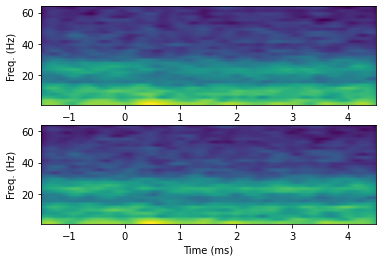

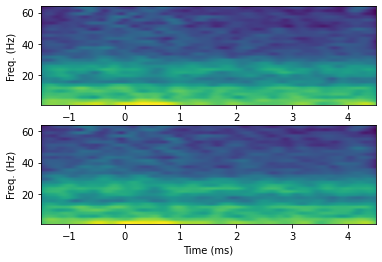

In [73]:
def plot_tfr(tfr, tvec, freq):
    extent = (tvec[0], tvec[-1], freq[0], freq[-1])
    
    plt.subplot(2,1,1)
    plt.imshow(tfr[0], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.subplot(2,1,2)
    plt.imshow(tfr[2], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    
    plt.show()
    
plot_tfr(np.log(tfr[Ihands].mean(0)), epochs.times, freq)
plot_tfr(np.log(tfr[ Ifeet].mean(0)), epochs.times, freq)

In [74]:
fbands = dict(
    delta = (freq[0], 4), 
    theta = (4, 8), 
    alpha = (8, 13),
    beta  = (13, 30), 
    gamma = (30, freq[-1])
)

idxs = {k: np.where(np.logical_and(freq >= fmin, freq < fmax))[0]
       for k, (fmin, fmax) in fbands.items()}

pband = {k: tfr[:,:,idx].sum(2) for k, idx in idxs.items()} 
acfs  = {k: acf_welch(p) for k, p in pband.items()} 
rgs = {k: estimate_roughness(p, p) for k, p in pband.items()}


nlags = 50
for k, acf in acfs.items(): 
    
    if k == 'delta': continue
        
    fig = go.Figure()
    
        
    acf_recon = np.concatenate([acf[:,:,-nlags+1:],acf[:,:,:nlags+1]], axis=-1)
    lags      = np.arange(-nlags+1, nlags+1)
        
    n = acf.shape[-1]
    acf_sums  = acf[..., 0] + np.sum(2 * np.arange(n-1, 0, -1) * acf[...,1:n] **2, -1) / n
    acf_fit   = np.exp(-  lags[None, None, :]**2 * (rgs[k][:,:, None]) / 2 )
    
    print(f'{k}:\n' 
          f'    - sum of squares:     {acf_sums.mean():.2f} ({acf_sums.std():.2f})\n'
          f'    - known, theoretical: {np.sqrt(np.pi / (2*rg)):.2f}\n'
          f'    - knwon, sum of sq.:  {np.exp(- 2* lags**2 * (rg) ).sum():.2f}\n'
          f'    - unkn., theoretical: {np.sqrt(2* np.pi/ rgs[k]).mean():.2f}\n'
          f'    - unkn., sum of sq.:  {acf_fit.sum(-1).mean():.2f} ({acf_fit.sum(-1).std():.2f})\n')
#     plt.plot(lags, acf_recon**2)

    for i in range(acf.shape[0]):
        for j in range(acf.shape[1]):
            fig.add_scatter(x=lags, y=acf_recon[i,j]**2, showlegend=False, mode='lines', line_width=1, line_color='grey')
    
    fig.add_scatter(x=lags, y=acf_recon.mean((0,1))**2, showlegend=False, mode='lines', line_width=3, line_color='black')
    fig.add_scatter(x=lags, y=acf_fit.mean((0,1)), name='Gaussian fit',  showlegend=False, mode='lines', line_color='yellow', line_width=4, line_dash='dot')

    fig.add_scatter(x=lags, y=np.exp(- 2* lags**2 * (rg) ), name='Gaussian fit',  showlegend=False, mode='lines', line_color='red', line_width=4, line_dash='dash')
    fig.update_layout(template='simple_white', height=400, width=600)
    fig.show()

theta:
    - sum of squares:     36.90 (5.68)
    - known, theoretical: 39.63
    - knwon, sum of sq.:  39.57
    - unkn., theoretical: 35.94
    - unkn., sum of sq.:  35.88 (4.71)



alpha:
    - sum of squares:     42.16 (8.06)
    - known, theoretical: 39.63
    - knwon, sum of sq.:  39.57
    - unkn., theoretical: 43.42
    - unkn., sum of sq.:  42.99 (6.96)



beta:
    - sum of squares:     43.61 (6.89)
    - known, theoretical: 39.63
    - knwon, sum of sq.:  39.57
    - unkn., theoretical: 44.81
    - unkn., sum of sq.:  44.34 (6.51)



gamma:
    - sum of squares:     41.07 (7.26)
    - known, theoretical: 39.63
    - knwon, sum of sq.:  39.57
    - unkn., theoretical: 42.05
    - unkn., sum of sq.:  41.51 (8.23)



In [75]:
pearson_rs  = {k: pearson_r(p[:, :, None], p[:, None, :]) for k, p in pband.items()}


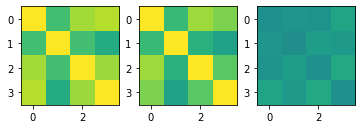

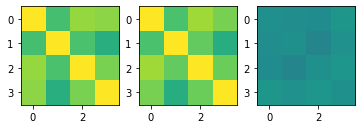

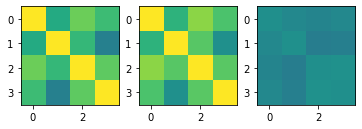

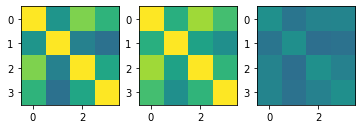

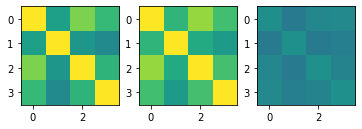

In [76]:
for k, r in pearson_rs.items():
    plt.subplot(1,3,1)
    plt.imshow(r[epochs.events[:,2] == 2].mean(0), vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(r[epochs.events[:,2] == 3].mean(0), vmin=0, vmax=1)
    plt.subplot(1,3,3)
    plt.imshow(r[epochs.events[:,2] == 2].mean(0) - r[epochs.events[:,2] == 3].mean(0), vmin=-0.5, vmax=0.5)


    plt.show()

In [ ]:
pearson_stats  = {k: stats_summary(pearson_r,  p[:, :, None], p[:, None, :], n_surrogates=1000) for k, p in pband.items()}
# spearman_stats = {k: stats_summary(spearman_r, p[:, 0], p[:, 1], n_surrogates=1000) for k, p in pband.items()}

In [35]:
pband['alpha'].shape

(45, 3, 960)

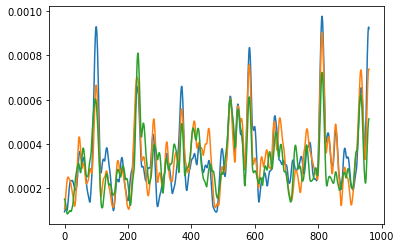

In [41]:
plt.plot(pband['beta'][3].T)